In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Data

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv", index_col=0)
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [3]:
len(train_df)

891

## Explore Data

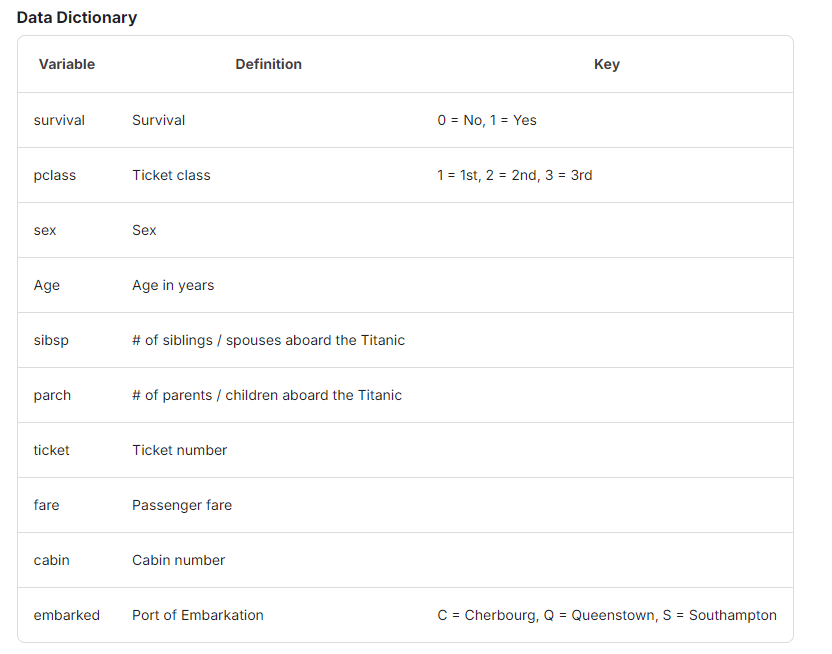

In [4]:
len(train_df)

891

In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# age has some null value
# should we try dropping them for now?

# count of rows that will be dropped
print(f"count of items to be dropped {len(train_df) - 714}")

# rows lefr
print(f"count of items left {len(train_df) - len(train_df) + 714}")

count of items to be dropped 177
count of items left 714


In [7]:
train_df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
# cabin has 687 nulls, i dont think we can learn anything using it though

In [9]:
# lets check balance now
train_df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [10]:
class_percentages = train_df["Survived"].value_counts(normalize=True) * 100

print(class_percentages)

threshold = 70  # Adjust this as needed
is_balanced = all(class_percentages < threshold)

if is_balanced:
    print("The dataset is balanced.")
else:
    print("The dataset is imbalanced.")

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64
The dataset is balanced.


In [11]:
# so model can easily get 61% accuracy if it always predics 0
# so this will be our basepoint

In [12]:
# check outliers
# Identify outliers for each column
for column in train_df.select_dtypes(include=[np.number]):  # Only numerical columns
    Q1 = train_df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = train_df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Column: {column}")
    print(f"Outliers: {len(train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)][column].tolist())}")

Column: Survived
Outliers: 0
Column: Pclass
Outliers: 0
Column: Age
Outliers: 11
Column: SibSp
Outliers: 46
Column: Parch
Outliers: 213
Column: Fare
Outliers: 116


## Create Dataset Class

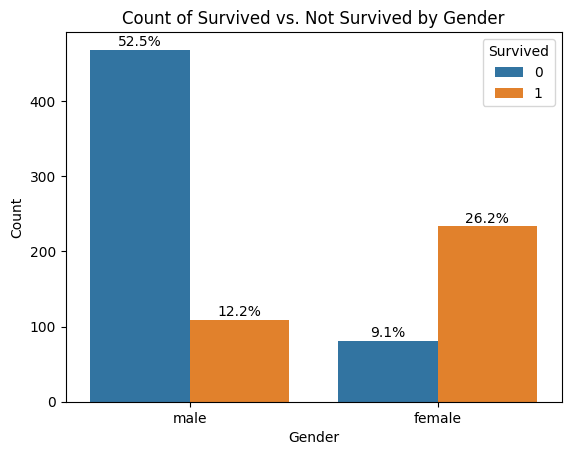

In [13]:
sns.countplot(x='Sex', hue='Survived', data=train_df)

total = len(train_df)

# Add percentage annotations

for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of each bar
    percentage = height / total * 100
    plt.text(x + width / 2, y + height + 5, f'{percentage:.1f}%', ha='center')

plt.title('Count of Survived vs. Not Survived by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


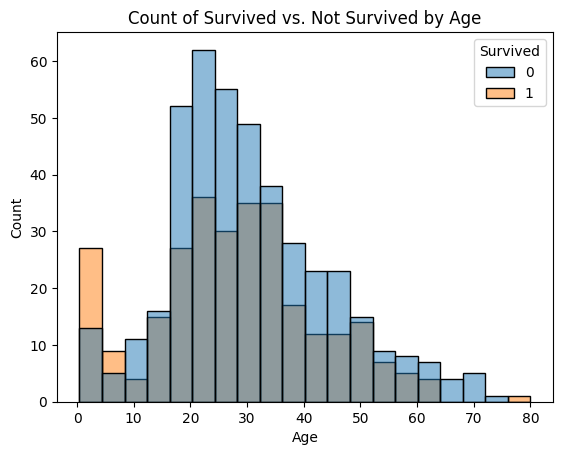

In [14]:
sns.histplot(x='Age', hue='Survived', data=train_df)
plt.title('Count of Survived vs. Not Survived by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [15]:
train_df["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [16]:
!pip install torchviz

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn 
from torch.utils.data import random_split
import math
from torchviz import make_dot
from IPython.display import Image

In [18]:
torch.manual_seed(42); # seed rng for reproducibility

In [19]:
class CSVDataset(Dataset):
    def __init__(self, csv_path, features_col_list, target_col_list, transform=None, dropNa=False):
        # data loading
        self.features_col_list = features_col_list
        self.target_col_list = target_col_list
        self.data = pd.read_csv(csv_path, index_col=0)
        self.transform = transform

        if (dropNa):
            self.data = self.data.dropna(subset=features_col_list)

    def __getitem__(self, index):
        x = self.data.iloc[index][self.features_col_list]  # Features}
        y = self.data.iloc[index][self.target_col_list]  # Target

        # Apply transformations if specified
        if self.transform:
            x, y = self.transform((x,y))

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # allow us to use len(dataset)
        return len(self.data)

In [20]:
class SexToNum():
    def __call__(self, sample):
        inputs, targets = sample

        if (inputs["Sex"] == "male"):
            inputs["Sex"] = 0
        else:
            inputs["Sex"] = 1

        return (inputs, targets)

class ConvertNumpyArrToFloat32():
    def __call__(self, sample):
        inputs, targets = sample
        inputs = (inputs.values).astype(np.float32)
        targets = (targets.values).astype(np.float32)
        return (inputs, targets)

In [21]:
csv_file = "/kaggle/input/titanic/train.csv"
features_col_list = ["Sex"]
target_col_list = ["Survived"]

transforms = torchvision.transforms.Compose([SexToNum(), ConvertNumpyArrToFloat32()])

dataset = CSVDataset(csv_file, features_col_list, target_col_list, transform=transforms, dropNa=True)
dataset[0]

(tensor([0.]), tensor([0.]))

In [22]:
len(dataset)

891

In [23]:
# Define split ratios
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [24]:
# Define batch size
# since we have less data
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
# not correctly init
hidden_neuron = 128
debug = True

class LinearLayer(nn.Linear):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class ReLuLayer(nn.ReLU):
    def __init__(self, *args, **kwargs):
        # Call the parent constructor to initialize the Linear layer
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        self.output = super().forward(x)
        return self.output

class TitanicSurvivalPredictor(nn.Module):
    def __init__(self, hidden_neuron):
        super().__init__()

        # define layers
        self.layers = nn.ModuleList([
            LinearLayer(1, hidden_neuron),
            ReLuLayer(),
            LinearLayer(hidden_neuron, 1),
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

model = TitanicSurvivalPredictor(hidden_neuron)

In [27]:
bce_loss = nn.BCEWithLogitsLoss()

first_batch_input = None
first_batch_label = None
for inputs, labels in train_loader:
    first_batch_input = inputs
    first_batch_label = labels
    break

In [28]:
first_batch_pred_logits = model(first_batch_input)
first_batch_pred_prob = torch.sigmoid(first_batch_pred_logits)  # Apply sigmoid for binary classification
loss = bce_loss(first_batch_pred_prob, first_batch_label)
print(f"init loss: {loss.item()}")

init loss: 0.6949284076690674


In [29]:
def initParam(model):
    # Initialize weights using Xavier Normal
    for i, layer in enumerate(model.layers):
        if (isinstance(layer, LinearLayer)):
            if (i<len(model.layers)-1):
                nn.init.xavier_normal_(model.layers[i].weight, torch.nn.init.calculate_gain("relu")) 
            else:
                nn.init.xavier_normal_(model.layers[i].weight, torch.nn.init.calculate_gain("sigmoid")) * 100
            if layer.bias is not None:
                nn.init.zeros_(model.layers[i].bias)

initParam(model)

In [30]:
first_batch_pred_logits = model(first_batch_input)
first_batch_pred_prob = torch.sigmoid(first_batch_pred_logits)  # Apply sigmoid for binary classification
loss = bce_loss(first_batch_pred_prob, first_batch_label)
print(f"init loss: {loss.item()}")

init loss: 0.6987965106964111


In [31]:
print(torch.cuda.is_available())  # True if GPU is available, otherwise False

True


In [32]:
# less lr rate since can overfit easily
learning_rate = 1e-3
# less epoch as can easily overfit
num_epoch = 100

lossi_train = []
lossi_val = []

total_samples = len(train_dataset)
n_iter = math.ceil(total_samples / batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
bce_loss = nn.BCEWithLogitsLoss()
output_grads = []

model = model.to(device)

runFirstBatch = False
for epoch in range(num_epoch):
    train_loss = 0    
    for i, (inputs, labels) in enumerate(train_loader):        
        # forward pass
        # print(f"inputs: {inputs}")
        # print(f"labels: {labels}")
        inputs = inputs.to(device)
        labels = labels.to(device)

        # print(f"inputs device: {inputs.device}, labels device: {labels.device}, model device: {[param.device for param in model.parameters()]}")

        # reset grad
        optimizer.zero_grad()
        
        pred = model(inputs)
        # print(f"pred: {pred}")

        # calc loss
        loss = bce_loss(pred, labels)

        if (debug):
            for layer in model.layers:
                layer.output.retain_grad() # save gradients of non leaf tensors also
        
        # backward pass
        loss.backward()
        optimizer.step()

        loss = loss.log10()
        train_loss += loss.item()

        if (debug):
             break

    # copied it to array since running with no grad will set grad to None
    if (debug):
        curr_grads = {}
        for i, layer in enumerate(model.layers):
            curr_grads[f"{layer.__class__.__name__}: {i}"] = layer.output.grad.clone()

        output_grads.append(curr_grads)
    
    train_loss /= len(train_loader)
    lossi_train.append(train_loss)

    # validation phase
    model.eval()
    with torch.no_grad():  # Disable gradient computation for validation
        val_loss = 0
        
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            pred = model(inputs)
            
            loss = bce_loss(pred, labels)
            loss = loss.log10()
            val_loss += loss.item()
        
        val_loss /= len(val_loader)
        lossi_val.append(val_loss)
        

    # reset to train mode
    model.train()

    if ((epoch+1)%1000==0):
        print(f"Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # if (debug):
        # break

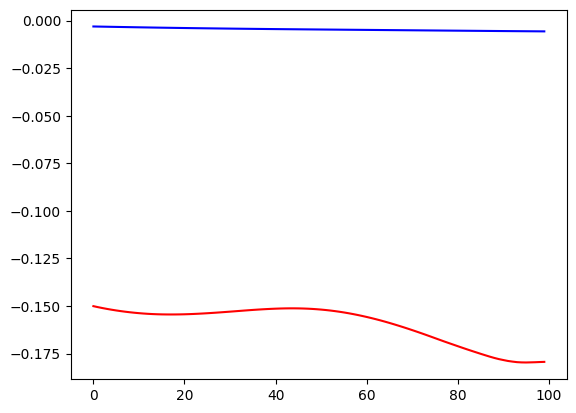

In [33]:
plt.plot(lossi_train, color="blue")
plt.plot(lossi_val, color="red")

layer 0 (LinearLayer): mean -0.01, std 0.09, saturated: 0.00%
layer 1 ( ReLuLayer): mean +0.02, std 0.06, saturated: 0.00%
layer 2 (LinearLayer): mean +0.29, std 0.55, saturated: 22.22%


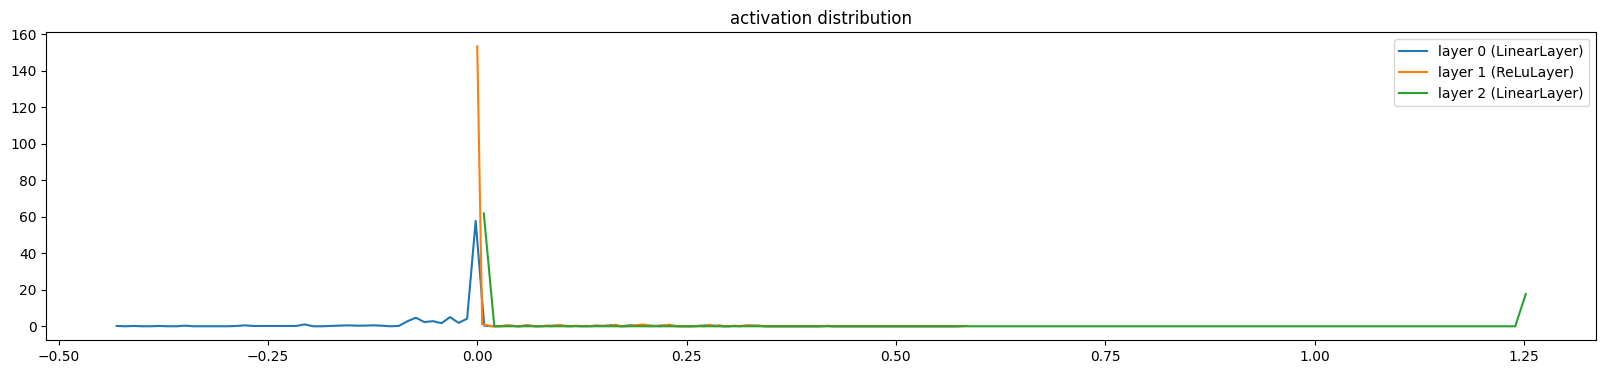

In [34]:
# visualize activations
plt.figure(figsize=(20, 4))
legends = []

if (len(model.layers) > 1):
    for i, layer in enumerate(model.layers): # exclude output layer
        t = layer.output.cpu()
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    
    plt.legend(legends)
    plt.title("activation distribution")

layer (LinearLayer: 0): mean +0.000001, std 2.009100e-03
layer (ReLuLayer: 1): mean +0.000036, std 3.730559e-03
layer (LinearLayer: 2): mean +0.001595, std 2.792139e-02


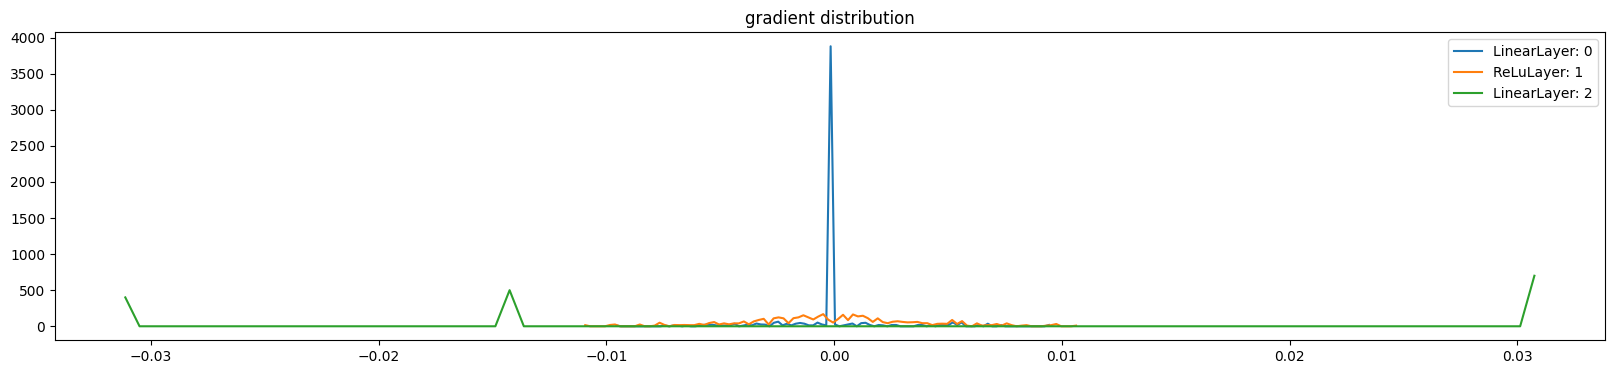

In [35]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

if (len(model.layers) > 1):
    for layer_name, layer_grad in output_grads[-1].items(): # note: exclude the output layer
        t = layer_grad.cpu()
        print('layer (%10s): mean %+f, std %e' % (layer_name, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{layer_name}')

    plt.legend(legends);
    plt.title('gradient distribution')

In [36]:
model.eval()  # Set model to evaluation mode

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
        correct += (predicted_classes == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 30.00%


In [37]:
model.eval()  # Set model to evaluation mode

# Accuracy calculation
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)
        correct += (predicted_classes == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 40.59%


## Test

In [38]:
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [39]:
len(test_df)

418

In [40]:
csv_file = "/kaggle/input/titanic/test.csv"
features_col_list = ["Sex"]
target_col_list = []

transforms = torchvision.transforms.Compose([SexToNum(), ConvertNumpyArrToFloat32()])

final_test_dataset = CSVDataset(csv_file, features_col_list, target_col_list, transform=transforms, dropNa=True)
final_test_dataset[0]

(tensor([0.]), tensor([]))

In [41]:
len(final_test_dataset)

418

In [42]:
final_test_loader = DataLoader(final_test_dataset, shuffle=False)

pred = []
with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in final_test_loader:
        inputs = inputs.to(device)
    
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid for binary classification
        predicted_classes = (predictions > 0.5).float()  # Convert to binary (0 or 1)

        pred.append(int(predicted_classes.item()))

In [43]:
len(final_test_loader)

418

In [44]:
pred_df = pd.DataFrame(pred, columns=["Survived"])
pred_df["PassengerId"] = test_df["PassengerId"]
pred_df.to_csv("pred.csv", index=False)

In [45]:
pred_df.head()

,Survived,PassengerId
0,1,892
1,1,893
2,1,894
3,1,895
4,1,896
